In [1]:
import pandas as pd
from datetime import datetime, timedelta
import math
import numpy as np
import warnings
from sklearn import linear_model
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
#Need to specify dtype of columns for every csv column for this and every other import

#the players number column, age, weight columns have NaN's in them probably can drop the number and weight columns
#as they are not features 
roster = pd.read_csv('stats_files/rosters', sep = '|')
#makes sure age matches this format and removes players which we don't have a birthdate for
#also excludes weird dates that might include dates over 31 or months over 12 or entries of 00
roster = roster[roster['Birthdate'].str.match('(\d\d\d\d)\-((?!00)0[1-9]|1[0-2])\-((?!00)(0[1-9]|[12]\d|3[01]))')]
#had two birthdates on september 31st just excluded them 
roster = roster[~roster['Birthdate'].str.match('(\d\d\d\d)\-09\-31')]

roster.shape

/Users/MattBarlowe/.virtualenvs/prospectmodel/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(136018, 13)

In [3]:
#Create the season start to calculate age at start of season for age adjusted statistics
roster['season_start'] = roster['season'].apply(lambda x: x - 1).apply('09-15-{}'.format)
roster['Birthdate'] = pd.to_datetime(roster['Birthdate'], format='%Y-%m-%d')
roster['season_start'] = pd.to_datetime(roster['season_start'], format='%m-%d-%Y')
roster['draft_cutoff'] = roster['season'].apply('09-15-{}'.format)
roster['draft_cutoff'] = pd.to_datetime(roster['draft_cutoff'], format='%m-%d-%Y')
#EP lists players Age as their current age instead of the age they were at the season
#I'm calculating their age as the age they are at the draft cutoff of that season
#in order to see if they are draft eligible that season. I have to calculate the players
#at sept. 15th of the draft year for that respective season. I then use that draft
#cutoff age to determine the years from their first draft eligible year
roster['Age'] = (roster['season_start'] - roster['Birthdate'])
roster['Age'] = roster['Age'] / timedelta(days=365.25)
roster['Age'] = roster['Age'].round(decimals=2)
roster['draft_cutoff_age'] = roster['draft_cutoff'] - roster['Birthdate']
roster['draft_cutoff_age'] = roster['draft_cutoff_age'] / timedelta(days=365.25)
roster['draft_cutoff_age'] = roster['draft_cutoff_age'].round(decimals=3)

In [4]:
#Remove goalies from the dataframe
roster = roster[roster['Position'] != 'G']
roster['Player'] = roster['Player'].str.strip()

In [5]:
#this function determines the years away from first draft eligible year for the season
#of the row i then apply it to the draft_cutoff_age column using pandas .apply() function
def draft_year(age):
    
    if age >=18 and age < 19:
        return 0
    else:
        return math.floor(age-18)
        
        
roster['draft_year'] = roster['draft_cutoff_age'].apply(draft_year)

In [6]:
#Join stats dataframe to the main roster dataframe
stats = pd.read_csv('stats_files/player_stats', sep='|')
stats['Player'] = stats['Player'].str.strip()
stats['team'] = stats['team'].str.strip()
stats = stats.groupby(['Player','season', 'team', 'team_id', 'player_id'], as_index=False).sum()

roster = roster.merge(stats[['player_id', 'season', 'GP', 'G', 'A', 'TP', 'PIM', 'playoff_GP',  
                           'playoff_G', 'playoff_A', 'playoff_TP', 'playoff_PIM', 'playoff_+/-', 'team_id', 'team']], 
                            on = ['player_id', 'season', 'team_id', 'team'])
#new_df[(new_df['team'] == 'Frölunda HC') & (new_df['season']==2018)]

In [7]:

#converting height into decimal values of feet
def clean_height(value):
    '''
    Function to convert height meausered in feet and inches to a decimal
    value
    Input:
    value - height measured in feet and inches
    Output:
    decimal_value - height returned in feet and inches converted to a decimal
                    value of feet
    '''
    try:
        value = value.replace("'", '.').replace(' ', '').replace('"', '')
        value_list = value.split('.')
        value_list[1] = float(value_list[1])/12
        value = float(value_list[0]) + value_list[1]
        value = round(value, 2)
    except IndexError as ex:
        value = ''

    return value

roster['HT'] = roster['HT'].astype('str').apply(clean_height)


In [8]:
#joining league data to the dataframe
leagues_hist = pd.read_csv('stats_files/leagues_hist_table', sep='|')

roster = roster.merge(leagues_hist[['league', 'season', 'team_id']], on=['season', 'team_id'])

In [9]:
#reads in draft data and the NHL stats of each drafted player and then joins it to the 
#master dataframe
nhl_draft_data = pd.read_csv('stats_files/nhl_draft_stats', sep='|')

nhl_draft_data = nhl_draft_data.rename(index=str, columns={'G':'nhl_G', 'GP':'nhl_GP', 'A':'nhl_A', 'TP':'nhl_TP'})
roster = roster.merge(nhl_draft_data[['nhl_GP', 'nhl_G', 'nhl_A', 'nhl_TP', 'player_id']], on=['player_id'],
                      how = 'left')
roster = roster.fillna(value=0)

In [10]:
#create goal to total points ratios
roster['goals_to_points'] = roster['G']/roster['TP']
roster['goals_to_points'] = roster['goals_to_points'].fillna(value=0)
roster['goals_to_points'] = roster['goals_to_points'].round(decimals=2)

#calculate points per game
roster['pts_per_gp'] = roster['TP']/roster['GP']
roster['pts_per_gp'] = roster['pts_per_gp'].fillna(value = 0)
roster['pts_per_gp'] = roster['pts_per_gp'].round(decimals=2)

In [11]:
#creating df for age to points regresion stopped at 20 because the regression become negatives as younger players
#graduate to professional leagues
age_adj_score_df = roster[(roster.Age < 20) & (roster.GP >30)]

In [12]:
#splitting into defense and forwards
age_adj_def_df = age_adj_score_df[age_adj_score_df.Position == 'D']
age_adj_fwd_df = age_adj_score_df[age_adj_score_df.Position != 'D']

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


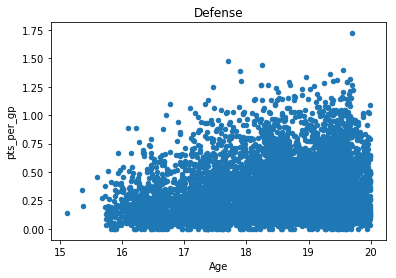

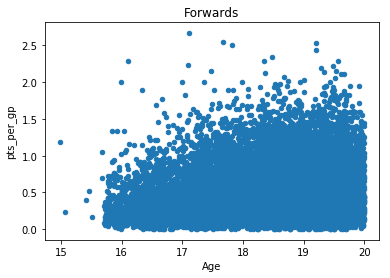

In [14]:
#graphing the correlation between age and points per game 
import matplotlib.pyplot as plt
ax1 = age_adj_def_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax2 = age_adj_fwd_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax1.set_title('Defense')
ax2.set_title('Forwards')
print(ax1)
print(ax2)

In [15]:
#getting the coef and yint of the linear regression for points age adj.
def_adj_model = linear_model.LinearRegression()
def_adj_model.fit(age_adj_def_df[['Age']].values, age_adj_def_df['pts_per_gp'].values)
def_model_coef = round(def_adj_model.coef_[0], 3)
def_model_yint = round(def_adj_model.intercept_, 3)
fwd_adj_model = linear_model.LinearRegression()
fwd_adj_model.fit(age_adj_fwd_df[['Age']].values, age_adj_fwd_df['pts_per_gp'].values)
fwd_model_coef = round(fwd_adj_model.coef_[0], 3)
fwd_model_yint = round(fwd_adj_model.intercept_, 3)

/Users/MattBarlowe/.virtualenvs/prospectmodel/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [16]:
#subset main dataframe for only those players in their first draft year and split into forwards and 
#and defnse to calculate age adjusted points per game
draft_year_df = roster[roster['draft_year'] == 0]
draft_year_df_def = draft_year_df[draft_year_df.Position == 'D']
draft_year_df_fwd = draft_year_df[draft_year_df.Position != 'D']

In [19]:
#creating adjusted pts per game for forwards and defense
draft_year_df_def['age_adj_pts_g'] = (1- ((draft_year_df_def['Age']-17) * def_model_coef)) \
                                        * draft_year_df_def['pts_per_gp']
draft_year_df_fwd['age_adj_pts_g'] = (1- ((draft_year_df_fwd['Age']-17) * fwd_model_coef)) \
                                        * draft_year_df_fwd['pts_per_gp']

#(1 - ([Age as of September of draft year - 17] * 0.1672)) * Pts/GP as from Rhys Jessop formula

/Users/MattBarlowe/.virtualenvs/prospectmodel/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/MattBarlowe/.virtualenvs/prospectmodel/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
#concatting the fwds and def dataframes back together to form the old draft_year_df dataframe
frames = [draft_year_df_def, draft_year_df_fwd]
draft_year_df = pd.concat(frames)
draft_year_df = draft_year_df.fillna(value=0)

In [46]:
draft_year_df.nhl_G = draft_year_df.nhl_G.astype('float')
draft_year_df.nhl_TP = draft_year_df.nhl_TP.astype('float')

In [47]:
draft_year_df['nhl_pts_per_gp'] = draft_year_df['nhl_TP'] / draft_year_df['nhl_GP']

In [60]:
draft_year_df['200_plus_nhl_gp'] = np.where(draft_year_df['nhl_GP']>=200, 1, 0)
draft_year_df['>_than_.2_pts_gp'] = np.where(draft_year_df['nhl_pts_per_gp']>=.50, 1, 0)

In [50]:
from IPython.display import display
pd.options.display.max_columns = None
display(draft_year_df[draft_year_df['>_than_.2_pts_gp'] == 1].iloc[:, 1:])

,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,league,nhl_GP,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp,age_adj_pts_g,nhl_pts_per_gp,50_plus_nhl_gp,>_than_.5_pts_gp,>_than_.2_pts_gp
21631,Oliver Ekman Larsson,17.17,D,1991-07-17,Tingsryds AIF,6.17,201,L,7693,28,2009,Leksands IF,2008-09-15,2009-09-15,18.166,0,39,3,14,17,32,8,2,2,4,6,2,Allsvenskan,576.0,102.0,188,290.0,0.18,0.44,0.436110,0.503472,1,0,1
48229,Sami Niku,17.93,D,1996-10-10,"Haapavesi, FIN",6,176,L,92502,42,2015,JYP,2014-09-15,2015-09-15,18.930,0,13,0,1,1,6,0,0,0,0,0,0,Liiga,1.0,1.0,0,1.0,0.00,0.08,0.076131,1.000000,0,1,1
55139,Sami Niku,17.93,D,1996-10-10,"Haapavesi, FIN",6,176,L,92502,10602,2015,JYP-Akatemia,2014-09-15,2015-09-15,18.930,0,39,3,22,25,24,6,0,5,5,4,2,Mestis,1.0,1.0,0,1.0,0.12,0.64,0.609050,1.000000,0,1,1
74641,Zach Werenski,17.16,D,1997-07-19,"Grosse Pointe, MI, USA",6.17,209,L,186311,803,2015,Univ. of Michigan,2014-09-15,2015-09-15,18.157,0,35,9,16,25,8,0,0,0,0,0,0,NCAA,155.0,27.0,57,84.0,0.36,0.71,0.704093,0.541935,1,0,1
75043,Charlie McAvoy,17.73,D,1997-12-21,"Long Beach, NY, USA",6,207,R,245142,633,2016,Boston Univ.,2015-09-15,2016-09-15,18.735,0,37,3,22,25,56,0,0,0,0,0,0,NCAA,63.0,7.0,25,32.0,0.12,0.68,0.654187,0.507937,1,0,1
79182,Brent Burns,17.52,D,1985-03-09,"Barrie, ON, CAN",6.42,4229,R,9103,867,2003,Brampton Battalion,2002-09-15,2003-09-15,18.519,0,68,15,25,40,14,11,5,6,11,6,0,OHL,961.0,182.0,384,566.0,0.38,0.59,0.574046,0.588970,1,0,1
81455,P.K. Subban,17.34,D,1989-05-13,"Toronto, ON, CAN",6,214,R,11251,866,2007,Belleville Bulls,2006-09-15,2007-09-15,18.341,0,68,15,41,56,89,15,5,8,13,26,11,OHL,582.0,89.0,288,377.0,0.27,0.82,0.805502,0.647766,1,0,1
82111,Drew Doughty,17.77,D,1989-12-08,"London, ON, CAN",6.08,194,R,10430,552,2008,Guelph Storm,2007-09-15,2008-09-15,18.771,0,58,13,37,50,68,10,3,6,9,14,5,OHL,770.0,102.0,320,422.0,0.26,0.86,0.825566,0.548052,1,0,1
82268,Alex Pietrangelo,17.66,D,1990-01-18,"King City, ON, CAN",6.25,201,R,11317,2231,2008,Niagara IceDogs,2007-09-15,2008-09-15,18.658,0,60,13,40,53,94,6,5,4,9,4,1,OHL,617.0,80.0,277,357.0,0.25,0.88,0.849798,0.578606,1,0,1
83946,Dougie Hamilton,17.25,D,1993-06-17,"Toronto, ON, CAN",6.5,209,R,45596,2231,2011,Niagara IceDogs,2010-09-15,2011-09-15,18.245,0,67,12,46,58,77,14,4,12,16,16,7,OHL,423.0,64.0,156,220.0,0.21,0.87,0.858690,0.520095,1,0,1


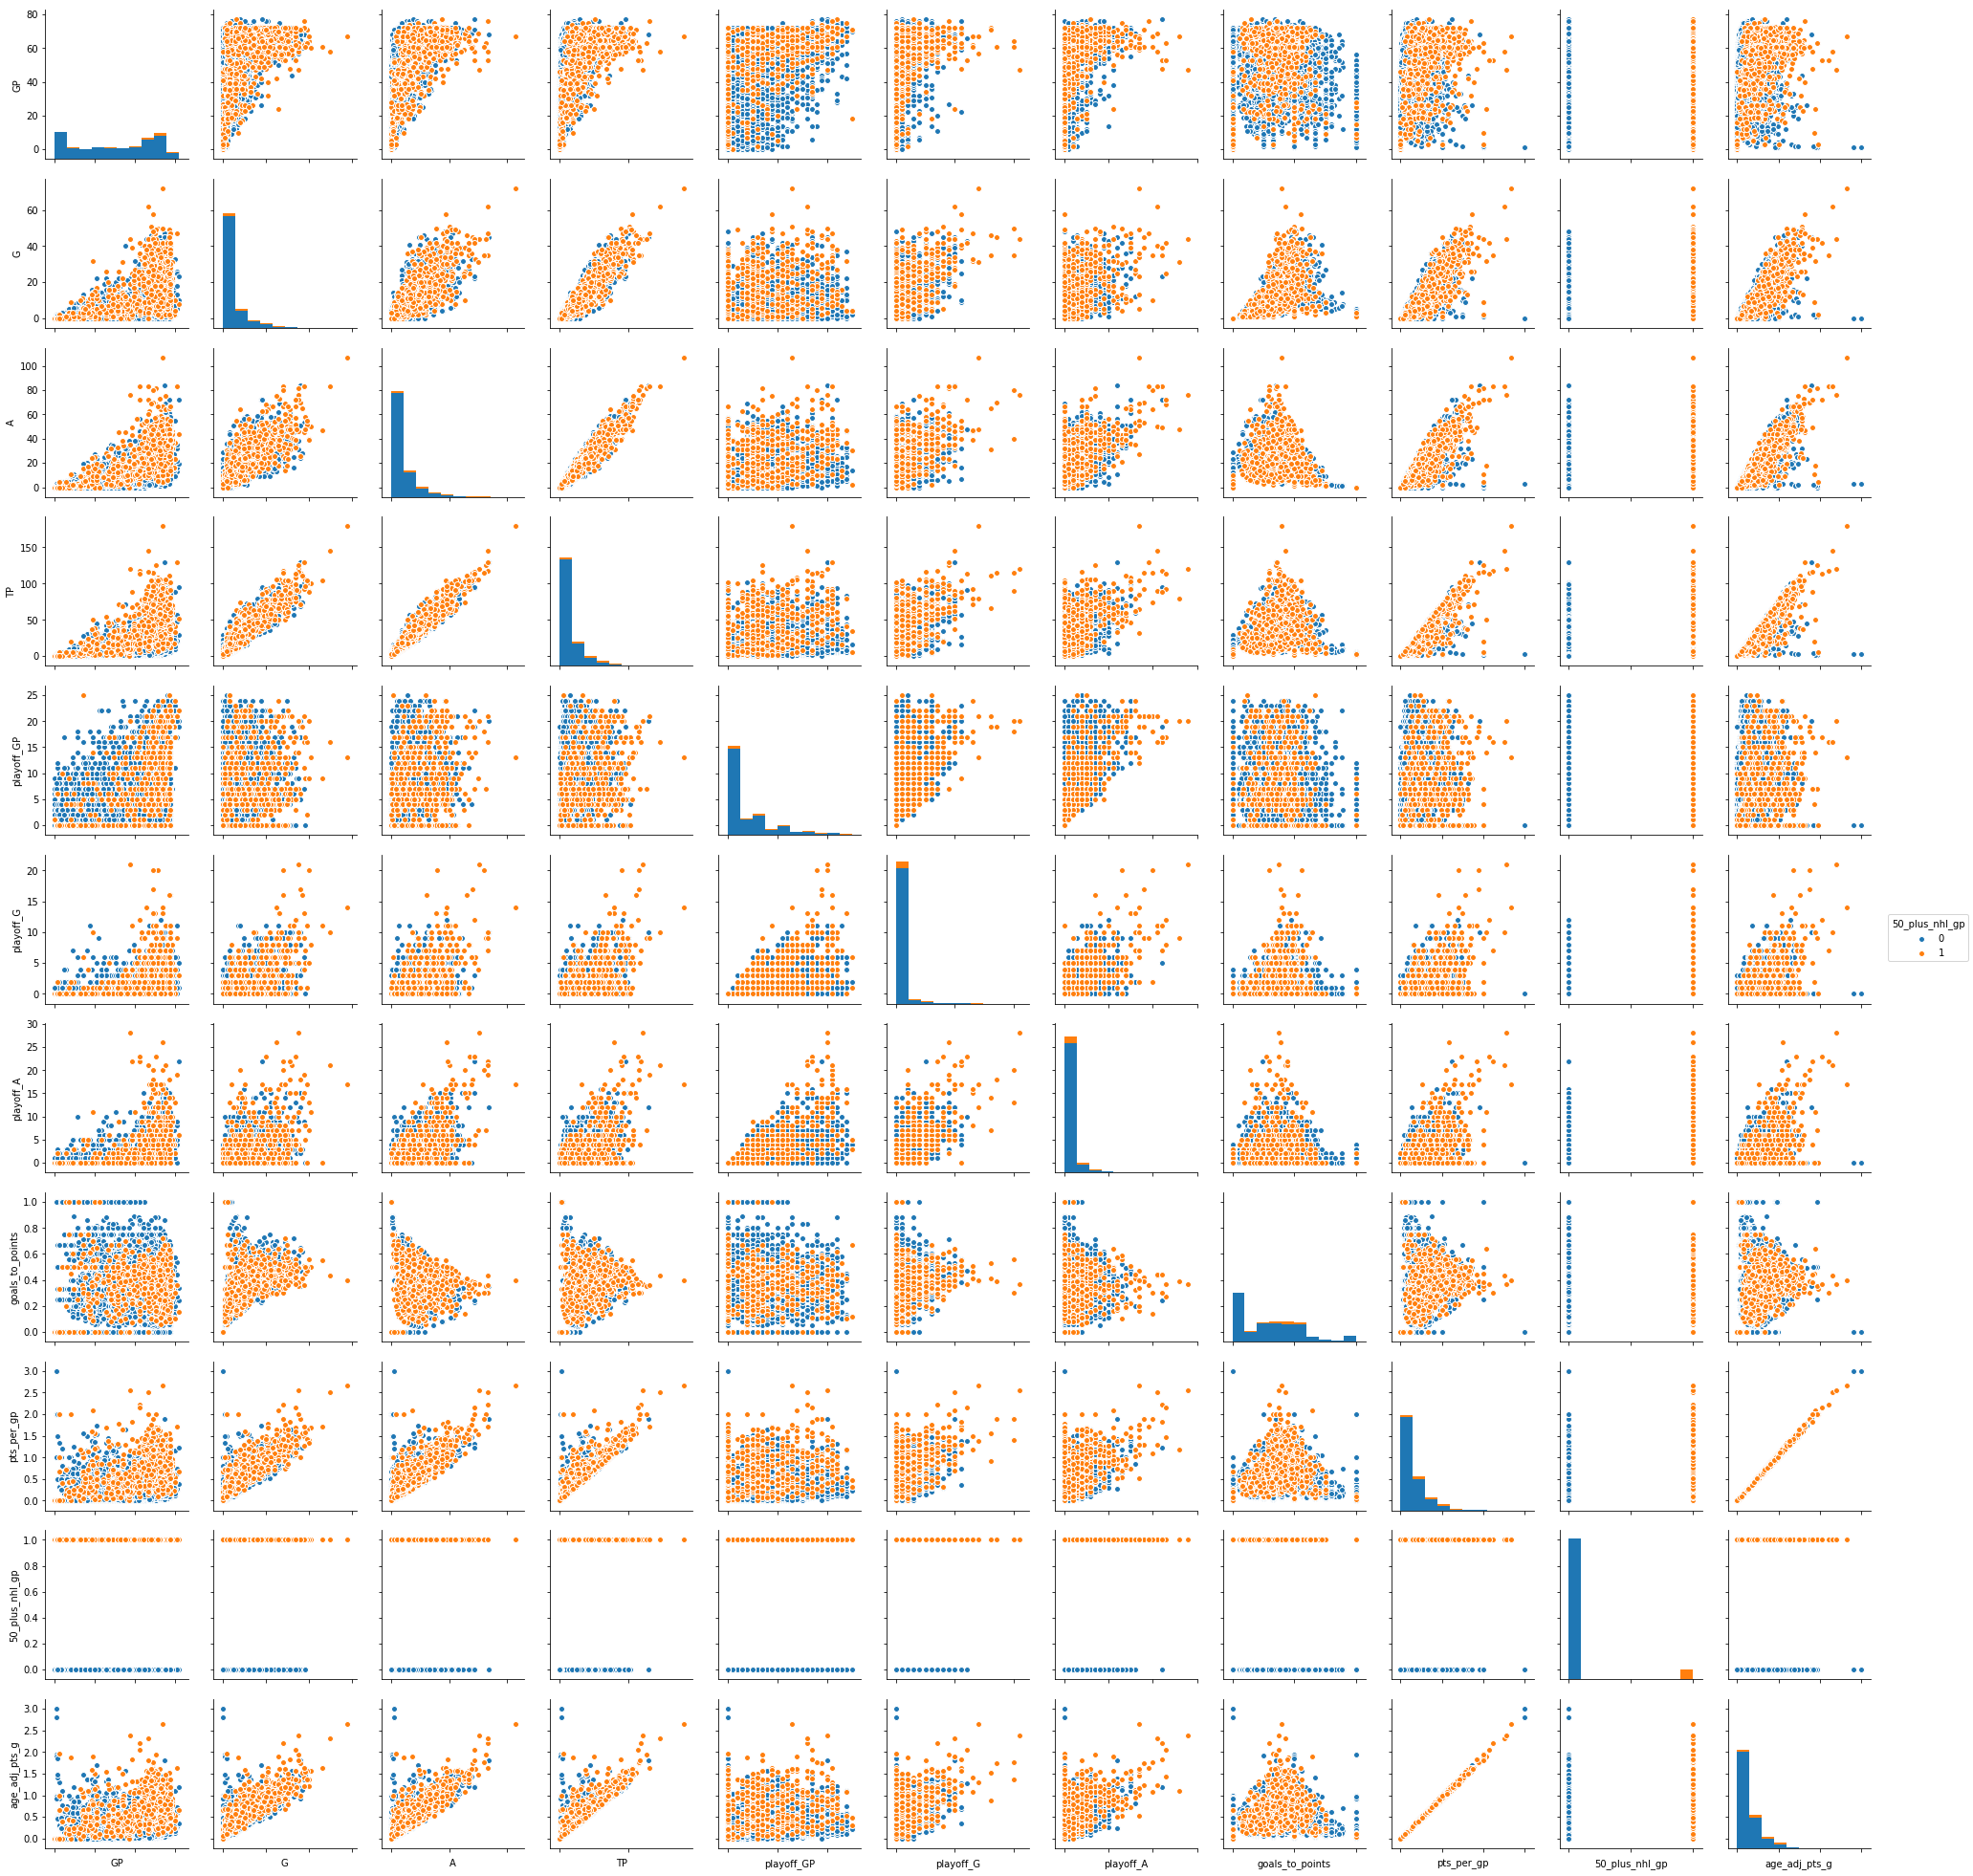

In [55]:
import seaborn as sns
g = sns.pairplot(draft_year_df[['HT', 'GP', 'G', 'A', 'TP', 'playoff_GP', 'playoff_G', 'playoff_A',
       'goals_to_points', 'pts_per_gp', '50_plus_nhl_gp', 'age_adj_pts_g']], hue='50_plus_nhl_gp', 
                  )
g.set(xticklabels=[])

In [56]:
draft_year_df[['HT', 'GP', 'G', 'A', 'TP', 'playoff_GP', 'playoff_G', 'playoff_A',
       'goals_to_points', 'pts_per_gp', '50_plus_nhl_gp', 'age_adj_pts_g']].corr()

,GP,G,A,TP,playoff_GP,playoff_G,playoff_A,goals_to_points,pts_per_gp,50_plus_nhl_gp,age_adj_pts_g
GP,1.000000,0.566136,0.640881,0.637905,0.499085,0.300164,0.340801,0.344528,0.430041,0.153394,0.432137
G,0.566136,1.000000,0.825016,0.936954,0.379463,0.575929,0.530972,0.405780,0.821577,0.336537,0.818563
A,0.640881,0.825016,1.000000,0.970450,0.438628,0.545969,0.615188,0.167563,0.841856,0.358469,0.842204
TP,0.637905,0.936954,0.970450,1.000000,0.433185,0.583595,0.607015,0.276709,0.871232,0.365520,0.870155
playoff_GP,0.499085,0.379463,0.438628,0.433185,1.000000,0.575253,0.653148,0.167660,0.318901,0.174366,0.320074
playoff_G,0.300164,0.575929,0.545969,0.583595,0.575253,1.000000,0.713742,0.152262,0.508508,0.291099,0.506597
playoff_A,0.340801,0.530972,0.615188,0.607015,0.653148,0.713742,1.000000,0.110776,0.517293,0.300166,0.517287
goals_to_points,0.344528,0.405780,0.167563,0.276709,0.167660,0.152262,0.110776,1.000000,0.324530,0.078562,0.322895
pts_per_gp,0.430041,0.821577,0.841856,0.871232,0.318901,0.508508,0.517293,0.324530,1.000000,0.357308,0.999353
50_plus_nhl_gp,0.153394,0.336537,0.358469,0.365520,0.174366,0.291099,0.300166,0.078562,0.357308,1.000000,0.358276


In [61]:
draft_year_df[draft_year_df['200_plus_nhl_gp'] == 1]

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,league,nhl_GP,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp,age_adj_pts_g,nhl_pts_per_gp,50_plus_nhl_gp,>_than_.5_pts_gp,>_than_.2_pts_gp,200_plus_nhl_gp
21631,3,Oliver Ekman Larsson,17.17,D,1991-07-17,Tingsryds AIF,6.17,201,L,7693,28,2009,Leksands IF,2008-09-15,2009-09-15,18.166,0,39,3,14,17,32,8,2,2,4,6,2,Allsvenskan,576.0,102.0,188,290.0,0.18,0.44,0.436110,0.503472,1,0,1,1
23021,5,Hampus Lindholm,17.65,D,1994-01-20,Jonstorps IF,6.17,207,L,34882,32,2012,Rögle BK,2011-09-15,2012-09-15,18.653,0,20,1,3,4,12,10,1,4,5,6,5,Allsvenskan,371.0,42.0,101,143.0,0.25,0.20,0.193240,0.385445,1,0,0,1
26511,15,Ladislav Smid,17.62,D,1986-02-01,"Frydlant, CZE",6.17,187,L,9225,700,2004,Bili Tygri Liberec,2003-09-15,2004-09-15,18.620,0,45,1,1,2,51,0,0,0,0,0,0,Extraliga,583.0,12.0,60,72.0,0.50,0.04,0.038710,0.123499,1,0,0,1
28519,5,Radko Gudas,17.28,D,1990-06-05,"Kladno, CZE",5.92,205,R,18085,646,2008,HC Kladno,2007-09-15,2008-09-15,18.281,0,0,0,0,0,0,1,0,0,0,0,0,Extraliga,339.0,20.0,65,85.0,0.00,0.00,0.000000,0.250737,1,0,0,1
34663,9,Dmitri Orlov,17.15,D,1991-07-23,"Novokuznetsk, RUS",5.92,212,L,17758,194,2009,Metallurg Novokuznetsk,2008-09-15,2009-09-15,18.149,0,15,1,0,1,4,0,0,0,0,0,0,KHL,365.0,30.0,94,124.0,1.00,0.07,0.069454,0.339726,1,0,0,1
47577,55,Rasmus Ristolainen,17.89,D,1994-10-27,"Turku, FIN",6.33,218,R,43497,48,2013,TPS,2012-09-15,2013-09-15,18.886,0,59,4,14,18,50,0,0,0,0,0,0,Liiga,346.0,31.0,120,151.0,0.22,0.31,0.295653,0.436416,1,0,0,1
52389,18,Sami Vatanen,17.29,D,1991-06-03,"Jyväskylä, FIN",5.83,187,R,16044,2846,2009,D Team,2008-09-15,2009-09-15,18.286,0,5,1,1,2,8,0,0,0,0,0,0,Mestis,337.0,36.0,118,154.0,0.50,0.40,0.393968,0.456973,1,0,0,1
70659,19,Jake McCabe,17.92,D,1993-10-12,"Eau Claire, WI, USA",6.08,209,L,45419,452,2012,Univ. of Wisconsin,2011-09-15,2012-09-15,18.927,0,26,3,9,12,12,0,0,0,0,0,0,NCAA,215.0,10.0,37,47.0,0.25,0.46,0.437994,0.218605,1,0,0,1
71940,22,Brett Pesce,17.83,D,1994-11-15,"Bronxville, NY, USA",6.25,201,R,121869,1136,2013,Univ. of New Hampshire,2012-09-15,2013-09-15,18.834,0,38,1,5,6,10,0,0,0,0,0,0,NCAA,216.0,9.0,46,55.0,0.17,0.16,0.153094,0.254630,1,0,0,1
73608,7,Noah Hanifin,17.64,D,1997-01-25,"Boston, MA, USA",6.25,205,L,177710,911,2015,Boston College,2014-09-15,2015-09-15,18.637,0,37,5,18,23,16,0,0,0,0,0,0,NCAA,239.0,18.0,65,83.0,0.22,0.62,0.599366,0.347280,1,0,0,1


In [59]:
draft_year_df.shape

(9833, 40)

In [175]:
#Splitting the data into 80/20 train test split with playing more than 50 games as the feature to predict 
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(draft_year_df[[
                                                                   'GP', 'G', 'A', 'TP',
                                                                   'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP',
                                                                   'goals_to_points', 'pts_per_gp', 'age_adj_pts_g']],
                                                    draft_year_df['50_plus_nhl_gp'], test_size=0.2)

In [176]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7866, 11) (7866,)
(1967, 11) (1967,)


In [178]:
#train the logistic regression
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [179]:
#get probability scores for each player playing over 50 games in NHL
predictions = logisticRegr.predict_proba(X_test)[:,1]


In [180]:
predict = logisticRegr.predict(X_test)

0.9898322318251144

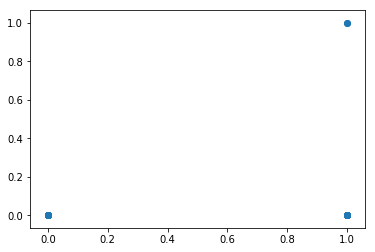

In [181]:
import matplotlib.pyplot as plt
plt.scatter(y_test, predict)
logisticRegr.score(X_test, y_test)

In [182]:
predictions_2018 = logisticRegr.predict_proba(draft_2018_df[['GP', 'G', 'A', 'TP',
                                                             'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_TP',
            
                                                             'goals_to_points', 'pts_per_gp', 'age_adj_pts_g']])[:,1]
predictions = logisticRegr.predict_proba(draft_year_df[['GP', 'G', 'A', 'TP',
                                                             'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_TP',
            
                                                             'goals_to_points', 'pts_per_gp', 'age_adj_pts_g']])[:,1]

In [183]:
draft_2018_df['>_.25_game_probs'] = predictions_2018
draft_year_df['>_.25_game_probs'] = predictions


Text(0.5,0,'NHL GP')

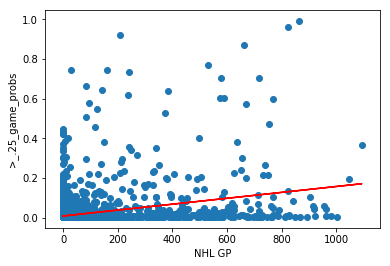

In [185]:
fig, ax = plt.subplots()
fit = np.polyfit(draft_year_df['nhl_GP'], draft_year_df['>_.25_game_probs'], deg=1)
ax.plot(draft_year_df['nhl_GP'], fit[0] * draft_year_df['nhl_GP'] + fit[1], color='red')
ax.scatter(draft_year_df['nhl_GP'], draft_year_df['>_.25_game_probs'])
plt.ylabel('>_.25_game_probs')
plt.xlabel('NHL GP')

In [187]:
draft_year_df = draft_year_df.sort_values(['>_.25_game_probs'], ascending=False)

In [189]:
draft_year_df[['Player', '>_.25_game_probs']].head(20)

,Player,>_.25_game_probs
89502,Sidney Crosby,0.992933
81643,Patrick Kane,0.961034
86037,Connor McDavid,0.922012
82478,Steven Stamkos,0.868355
83668,Taylor Hall,0.769975
86151,Mitchell Marner,0.746515
86041,Dylan Strome,0.742898
93846,Jonathan Drouin,0.735239
89779,Derick Brassard,0.703936
83310,Jeff Skinner,0.701914


In [190]:
draft_year_df[draft_year_df['Player']=='Nicklas Bäckström']

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,...,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp,age_adj_pts_g,nhl_pts_per_gp,50_plus_nhl_gp,>_than_.25_pts_gp,>_.25_game_probs
98124,19,Nicklas Bäckström,17.81,C,1987-11-23,Valbo AIF,6,214,L,3682,...,209.0,590,799,0.38,0.57,0.5266,0.256442,1,1,0.008003


In [194]:
draft_2018_df[['Player', '>_.25_game_probs']].groupby(['Player'], as_index=False).mean().sort_values(['>_.25_game_probs'], ascending=False).iloc[:50,:]

,Player,>_.25_game_probs
34,Andrei Svechnikov,0.446119
191,Filip Zadina,0.371219
415,Oliver Wahlstrom,0.300902
264,Joel Farabee,0.095312
228,Jack Drury,0.072660
182,Evan Bouchard,0.068338
13,Aidan Dudas,0.059805
276,Joseph Veleno,0.059653
17,Akil Thomas,0.057928
269,Johnny Gruden,0.054439


In [196]:
draft_rankings_2018 = draft_2018_df[['Player', '>_.25_game_probs']].groupby(['Player'], as_index=False).mean().sort_values(['>_.25_game_probs'], ascending=False)

In [197]:
draft_rankings_2018[(draft_rankings_2018['Player']=='Brady Tkachuk')]

,Player,>_.25_game_probs
67,Brady Tkachuk,0.010608
